# wprowadzenie i kilka słów o danych

Dane zebrane w formie pliku .csv ze strony https://ai-jobs.net/, a także do analiz dodane dane skrapowane z tej strony na Kaggle oraz platformy LinkedIn.
Pobieranie niezbędnych bibliotek i danych ze strony internetowej

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re
from wordcloud import WordCloud
import plotly.graph_objects as go

pd.set_option('display.max_colwidth', None)

!pip install country_converter
!pip install pycountry -q
import pycountry


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 812.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 19.2 MB/s eta 0:00:00


In [3]:
#https://drive.google.com/file/d/1UpGuSH8FbqoJuqWYNrGo8oe0eA1PJ8RO/view?usp=sharing
data = pd.read_csv('https://drive.google.com/uc?id=1UpGuSH8FbqoJuqWYNrGo8oe0eA1PJ8RO', encoding='iso-8859-1')
data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,MI,FT,Applied Scientist,260000,USD,260000,US,0,US,L
1,2023,MI,FT,Applied Scientist,136000,USD,136000,US,0,US,L
2,2023,SE,FT,Data Engineer,152375,USD,152375,US,0,US,M
3,2023,SE,FT,Data Engineer,94000,USD,94000,US,0,US,M
4,2023,SE,FT,Data Analyst,82000,USD,82000,US,0,US,M
...,...,...,...,...,...,...,...,...,...,...,...
9501,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
9502,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
9503,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
9504,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9506 entries, 0 to 9505
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           9506 non-null   int64 
 1   experience_level    9506 non-null   object
 2   employment_type     9506 non-null   object
 3   job_title           9506 non-null   object
 4   salary              9506 non-null   int64 
 5   salary_currency     9506 non-null   object
 6   salary_in_usd       9506 non-null   int64 
 7   employee_residence  9506 non-null   object
 8   remote_ratio        9506 non-null   int64 
 9   company_location    9506 non-null   object
 10  company_size        9506 non-null   object
dtypes: int64(4), object(7)
memory usage: 817.0+ KB


In [5]:
for column in data.columns:
    num_distinct_values = len(data[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

work_year: 4 distinct values
experience_level: 4 distinct values
employment_type: 4 distinct values
job_title: 126 distinct values
salary: 1567 distinct values
salary_currency: 22 distinct values
salary_in_usd: 1858 distinct values
employee_residence: 86 distinct values
remote_ratio: 3 distinct values
company_location: 74 distinct values
company_size: 3 distinct values


In [6]:
data['experience_level'] = data['experience_level'].replace({
    'SE': 'Senior',
    'EN': 'Entry level',
    'EX': 'Executive level',
    'MI': 'Mid/Intermediate level',
})

data['employment_type'] = data['employment_type'].replace({
    'FL': 'Freelancer',
    'CT': 'Contractor',
    'FT' : 'Full-time',
    'PT' : 'Part-time'
})
data['company_size'] = data['company_size'].replace({
    'S': 'SMALL',
    'M': 'MEDIUM',
    'L' : 'LARGE',
})
data['remote_ratio'] = data['remote_ratio'].astype(str)
data['remote_ratio'] = data['remote_ratio'].replace({
    '0': 'On-Site',
    '50': 'Half-Remote',
    '100' : 'Full-Remote',
})

In [7]:
duplicate_rows = data[data.duplicated()]
duplicate_rows.shape

(4046, 11)

Nie będziemy usuwać "duplikatów", ponieważ możliwe jest, że są to podobne oferty od różnych pracodawców lub że jeden pracodawca poszukuje podobnych pracowników. Nie ma pewności, że są to naprawdę duplikaty oryginalnych ofert.
*jaki okres obejmują dane?*

In [8]:
data_values = data.work_year.value_counts()

# Create a pie chart
fig = go.Figure(data=go.Pie(
    labels=data_values.index,
    values=data_values.values,
    hole=0.4,
    textinfo='label+percent',
    insidetextorientation='radial',
    marker=dict(
        colors=px.colors.sequential.Teal,
        line=dict(
            color='green',
            width=2
        )
    ),
))
# Update layout
fig.update_layout(
    title="Rozkład danych w poszczególnych latach",
    annotations=[dict(text="Year Overview", showarrow=False, font_size=20)],
    height=600
)

# Show the pie chart
fig.show()

In [9]:
import country_converter as coco # in Google colab Country_converter to be installed
data1 = data.groupby('employee_residence')['salary_in_usd'].mean().reset_index()
data1['employee_residence']=coco.convert(names=data1['employee_residence'], to='ISO3')
fig=px.choropleth(data1,
                  locations='employee_residence',
                  color='salary_in_usd',
title='Distribution of Employer Headquarters by Country')
fig.show()

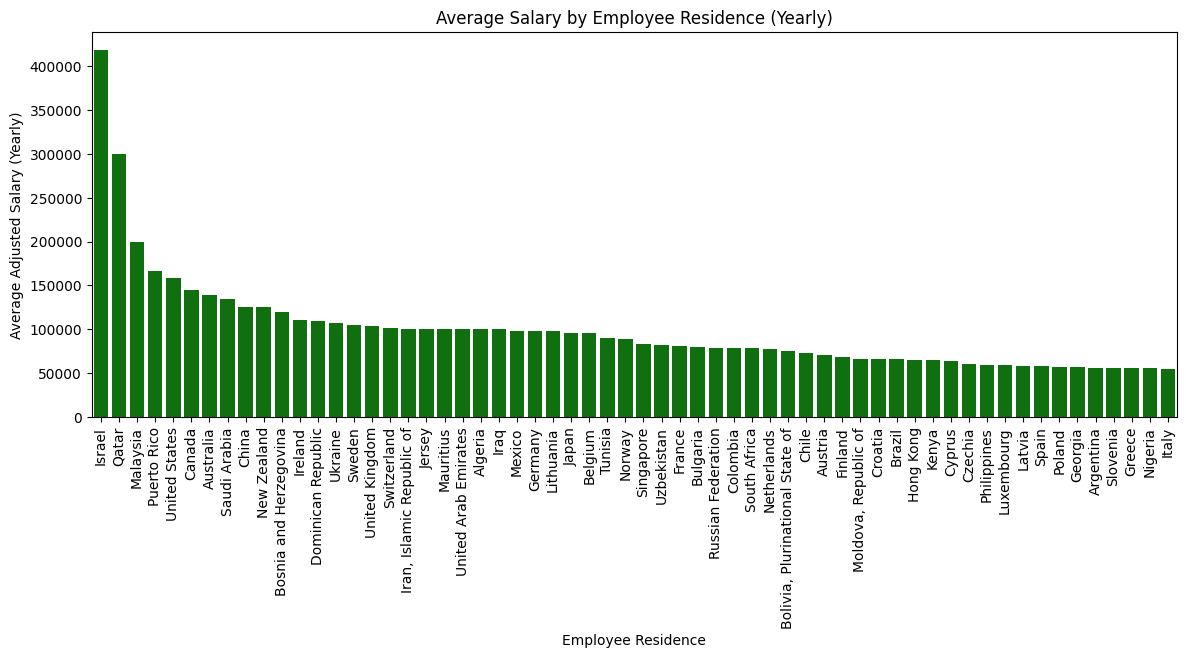

In [10]:
def country_code_to_name(code):
    try:
        country = pycountry.countries.get(alpha_2=code)
        return country.name
    except AttributeError:
        return code

# Average salary by employee_residence
avg_salary_by_residence = data.groupby('employee_residence')['salary_in_usd'].mean().sort_values(ascending=False)

# Limit to top 60 countries
avg_salary_by_residence = avg_salary_by_residence.head(60)

# Map ISO country codes to country names
avg_salary_by_residence.index = avg_salary_by_residence.index.map(country_code_to_name)

# Plotting
plt.figure(figsize=(14, 5))
sns.barplot(x=avg_salary_by_residence.index, y=avg_salary_by_residence.values, color='green')
plt.title('Average Salary by Employee Residence (Yearly)')
plt.xlabel('Employee Residence')
plt.ylabel('Average Adjusted Salary (Yearly)')
plt.xticks(rotation=90)
plt.show()


In [11]:
israel_data = data[data['employee_residence'] == 'IL']
israel_data

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
6328,2023,Senior,Full-time,AI Scientist,1500000,ILS,417937,IL,On-Site,IL,LARGE


Wartość ta nie może jednak charakteryzować poziomu wynagrodzeń w tym kraju, ponieważ jest tylko jedna.

In [12]:
count_by_country = data['employee_residence'].value_counts().reset_index()
count_by_country.columns = ['employee_residence', 'count']

fig = px.treemap(count_by_country,
                 path=['employee_residence'],
                 values='count',
                 title='Liczba propozycji według kraju',
                 color='count',
                 color_continuous_scale='viridis')

fig.show()


# wizualizacja i analiza zależności wynagrodzenia od warunków i poziomu doświadczenia pracownika

liczba ofert z określonym wynagrodzeniem w naszych danych

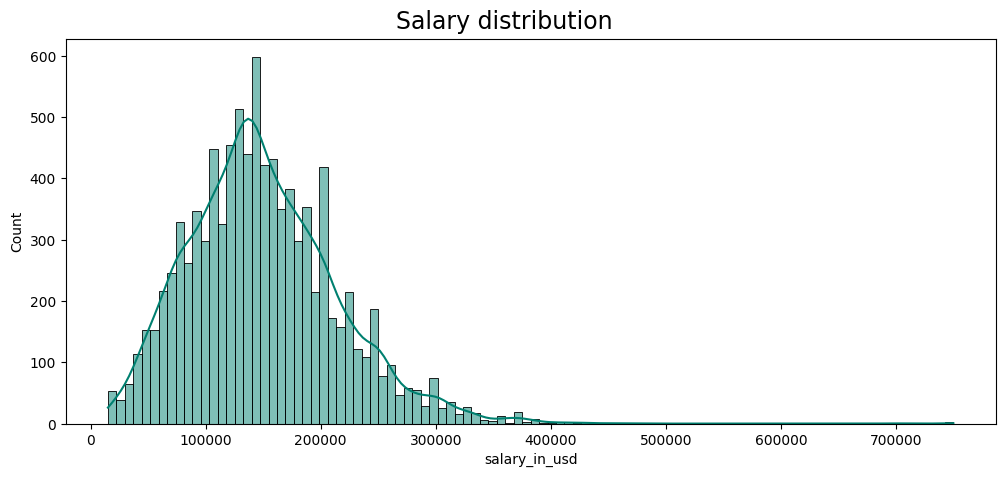

In [13]:
plt.figure(figsize=(12,5))

plt.gcf().text(.40, .90,
               "Salary distribution",
               fontsize = 17,
               color='Black')

sns.histplot(data['salary_in_usd'],
             bins=100,
             kde=True,
             color= '#008070'
             )

sns.set(rc={'xtick.labelsize':10,
            'ytick.labelsize':10})

plt.show()

In [15]:
frequency = data['salary_in_usd'].value_counts()
max_frequency_value = frequency.idxmax()
print(max_frequency_value)


150000


zdalnie czy w biurze?

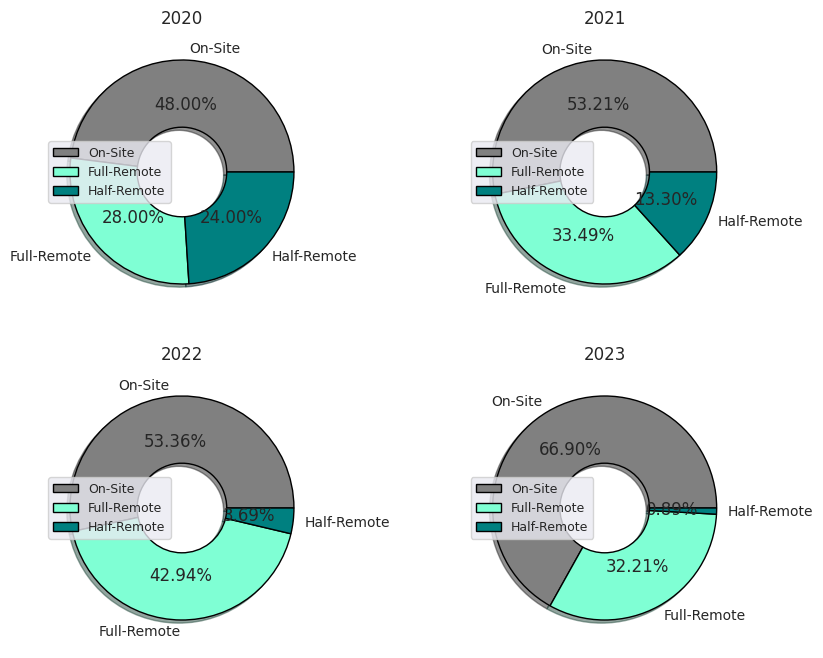

In [16]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

colors = ['grey', 'aquamarine', 'teal']
labels = data['remote_ratio'].value_counts().index

ax[0,0].pie(data.loc[data['work_year']==2020]['remote_ratio'].value_counts(),
        labels= labels,
        colors= colors,
        shadow = True,
        wedgeprops= {'edgecolor': 'black','width':0.6},
        autopct='%1.2f%%' )
ax[0,0].set_title('2020')

ax[0,1].pie(data.loc[data['work_year']==2021]['remote_ratio'].value_counts(),
        labels= labels,
        colors= colors,
        shadow = True,
        wedgeprops= {'edgecolor': 'black','width':0.6},
        autopct='%1.2f%%' )
ax[0,1].set_title('2021')

ax[1,0].pie(data.loc[data['work_year']==2022]['remote_ratio'].value_counts(),
            labels= labels,
        colors= colors,
        shadow = True,
        wedgeprops= {'edgecolor': 'black','width':0.6},
        autopct='%1.2f%%' )
ax[1,0].set_title('2022')

ax[1,1].pie(data.loc[data['work_year']==2023]['remote_ratio'].value_counts(),
        labels= labels,
        colors= colors,
        shadow = True,
        wedgeprops= {'edgecolor': 'black','width':0.6},
        autopct='%1.2f%%' )
ax[1,1].set_title('2023')



ax[0,0].legend(loc='center left', fontsize=9)
ax[0,1].legend(loc='center left', fontsize=9)
ax[1,0].legend(loc='center left', fontsize=9)
ax[1,1].legend(loc='center left', fontsize=9)

plt.show()

jak zmienia się wynagrodzenie i średnie wynagrodzenie w zależności od rodzaju zatrudnienia pracownika i jakie oferty są dostępne na rynku (contrakt, umowa freelancerska lub umowa o pracę...)


In [17]:
#df = pd.DataFrame(data)

# Tworzenie tabeli przestawnej
pivot_table = data.pivot_table(index='work_year', columns='employment_type', values='salary_in_usd', aggfunc='mean')

# Wydrukuj wyniki
print("Średnie wynagrodzenie dla każdego roku i typu zatrudnienia:")
print(pivot_table)

Średnie wynagrodzenie dla każdego roku i typu zatrudnienia:
employment_type     Contractor    Freelancer      Full-time     Part-time
work_year                                                                
2020              68251.000000  60000.000000  106759.811594  18817.500000
2021             263666.666667  41851.666667   99485.740385  43355.750000
2022              69545.250000  70130.750000  134984.331093  74578.833333
2023             105682.666667  39250.000000  155011.565333  69820.000000


<ipython-input-18-21c1c62c51b5>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-18-21c1c62c51b5>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-18-21c1c62c51b5>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-18-21c1c62c51b5>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




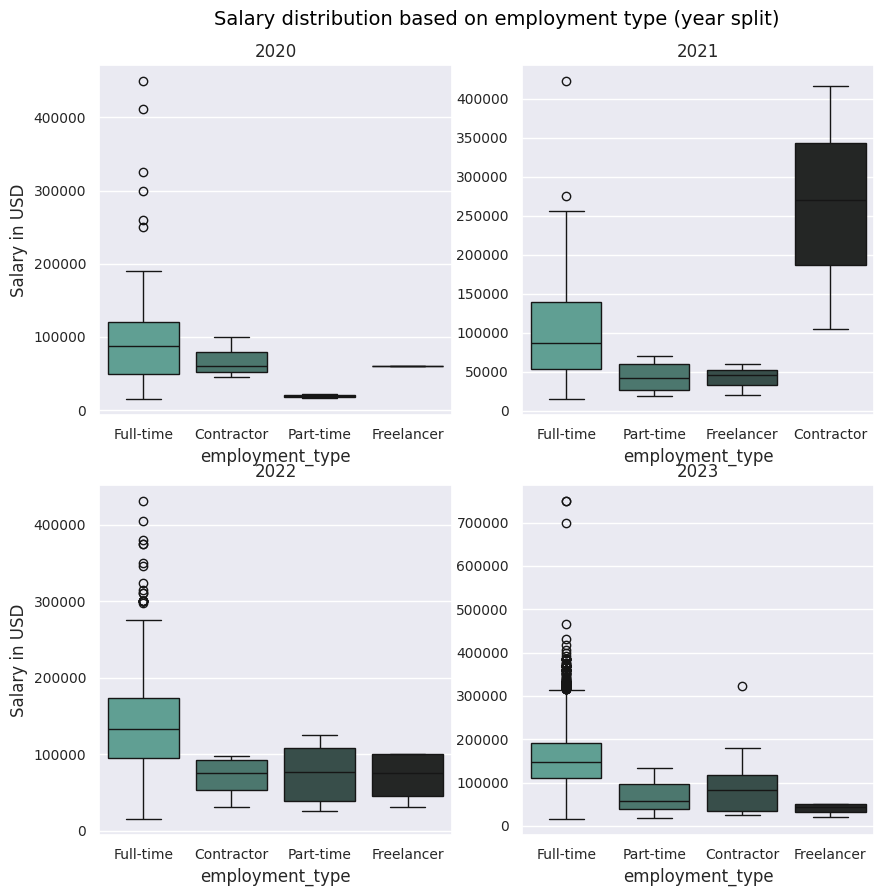

In [18]:
fig, ax = plt.subplots(2,2, figsize= (10, 10))


data20 = data.loc[data['work_year']==2020, ['employment_type', 'salary_in_usd']]
x20, y20 = data20['employment_type'], data20['salary_in_usd']
data21 = data.loc[data['work_year']==2021, ['employment_type', 'salary_in_usd']]
x21, y21 = data21['employment_type'], data21['salary_in_usd']
data22 = data.loc[data['work_year']==2022, ['employment_type', 'salary_in_usd']]
x22, y22 = data22['employment_type'], data22['salary_in_usd']
data23 = data.loc[data['work_year']==2023, ['employment_type', 'salary_in_usd']]
x23, y23 = data23['employment_type'], data23['salary_in_usd']

sns.set(rc={'xtick.labelsize':8,
            'ytick.labelsize':8})

plt.gcf().text(.24, .92,
               "Salary distribution based on employment type (year split)",
               fontsize = 14,
               color='Black')

sns.boxplot(ax=ax[0,0], x=x20, y=y20, palette='dark:#5A9_r').set(title=('2020'), xlabel=('employment_type'), ylabel=('Salary in USD'))
sns.boxplot(ax=ax[0,1], x=x21, y=y21, palette='dark:#5A9_r').set(title=('2021'), xlabel=('employment_type'), ylabel=(''))
sns.boxplot(ax=ax[1,0], x=x22, y=y22, palette='dark:#5A9_r').set(title=('2022'), xlabel=('employment_type'), ylabel=('Salary in USD'))
sns.boxplot(ax=ax[1,1], x=x23, y=y23, palette='dark:#5A9_r').set(title=('2023'), xlabel=('employment_type'), ylabel=(''))

plt.show()

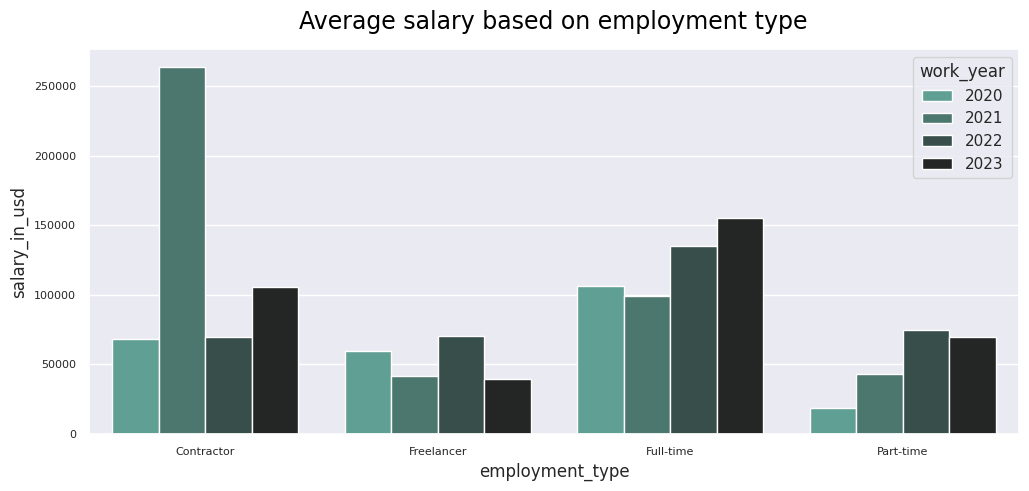

In [19]:
plt.figure(figsize=(12,5))
data_s3 = data.groupby(['work_year', 'employment_type']).salary_in_usd.mean().reset_index()

sns.barplot(x= data_s3['employment_type'], y= data_s3['salary_in_usd'], hue= data_s3['work_year'], palette='dark:#5A9_r')

sns.set(rc={'xtick.labelsize':10,
            'ytick.labelsize':10})

plt.gcf().text(.30, .92,
               "Average salary based on employment type",
               fontsize = 17,
               color='Black')


plt.show()

In [20]:
contractor_data_2021 = data[(data['employment_type'] == 'Contractor') & (data['work_year'] == 2021)]
contractor_data_2021


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
9301,2021,Mid/Intermediate level,Contractor,ML Engineer,270000,USD,270000,US,Full-Remote,US,LARGE
9391,2021,Senior,Contractor,Staff Data Scientist,105000,USD,105000,US,Full-Remote,US,MEDIUM
9433,2021,Executive level,Contractor,Principal Data Scientist,416000,USD,416000,US,Full-Remote,US,SMALL


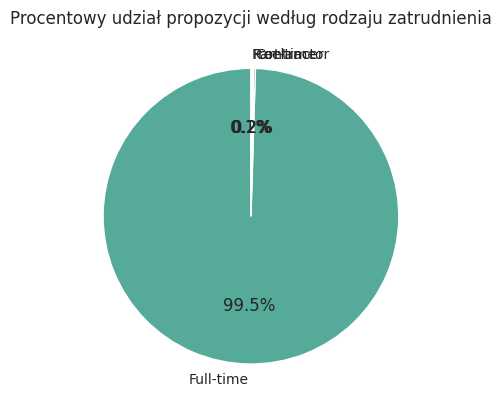

In [21]:
employment_data = data['employment_type'].value_counts()

sns.set_palette("dark:#5A9_r")
plt.pie(employment_data, labels=employment_data.index, autopct='%1.1f%%', startangle=90)

# Dodanie etykiety
plt.title('Procentowy udział propozycji według rodzaju zatrudnienia')

# Pokazanie wykresu
plt.show()

propozycji według poziomu doświadczenia

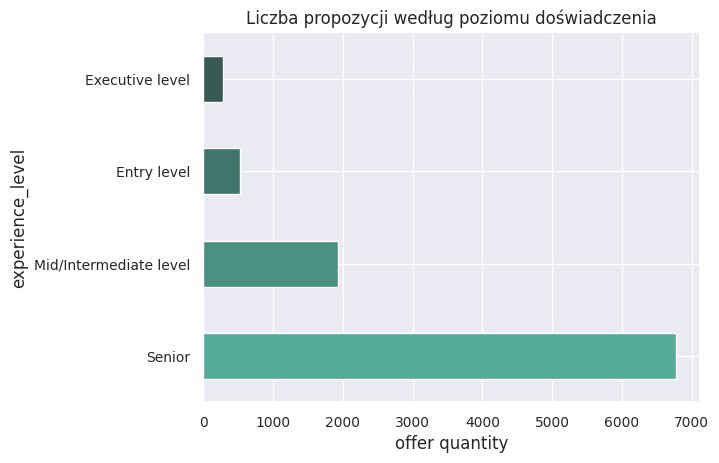

In [22]:
experience_data = data['experience_level'].value_counts()

# Rysowanie wykresu
sns.set_palette("dark:#5A9_r")
experience_data.plot(kind='barh', color=sns.color_palette())

# Ukrycie górnej i prawej krawędzi
plt.gca().spines[['top', 'right']].set_visible(False)

# Dodanie etykiet
plt.xlabel('offer quantity')
plt.ylabel('experience_level')
plt.title('Liczba propozycji według poziomu doświadczenia')

# Pokazanie wykresu
plt.show()

jak zmieniało się średnie wynagrodzenie za pracę w zależności od poziomu kompetencji pracownika

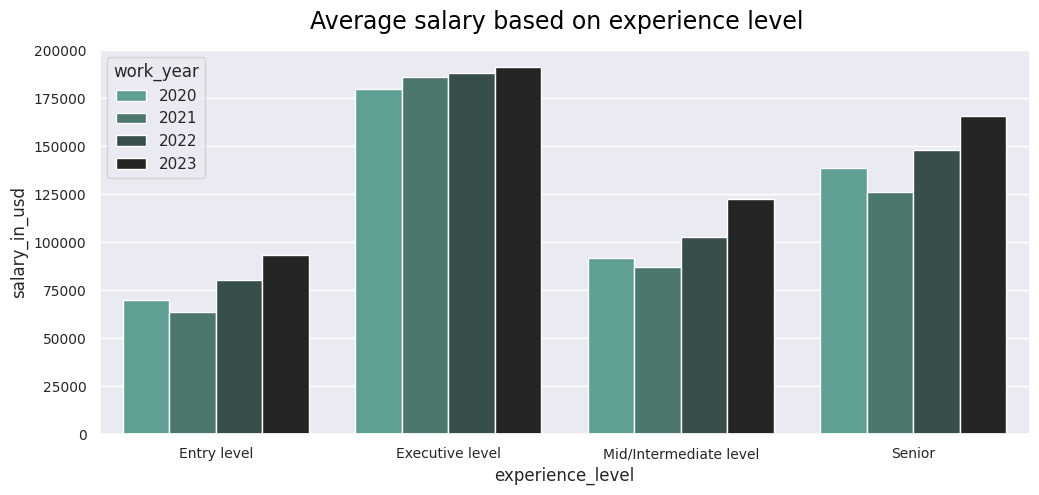

In [23]:
plt.figure(figsize=(12,5))
data_s1 = data.groupby(['work_year', 'experience_level']).salary_in_usd.mean().reset_index()

sns.barplot(x= data_s1['experience_level'], y= data_s1['salary_in_usd'], hue= data_s1['work_year'], palette='dark:#5A9_r')

sns.set(rc={'xtick.labelsize':10,
            'ytick.labelsize':10})

plt.gcf().text(.30, .92,
               "Average salary based on experience level",
               fontsize = 17,
               color='Black')


plt.show()


<ipython-input-25-b3dde14037c9>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-25-b3dde14037c9>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-25-b3dde14037c9>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-25-b3dde14037c9>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




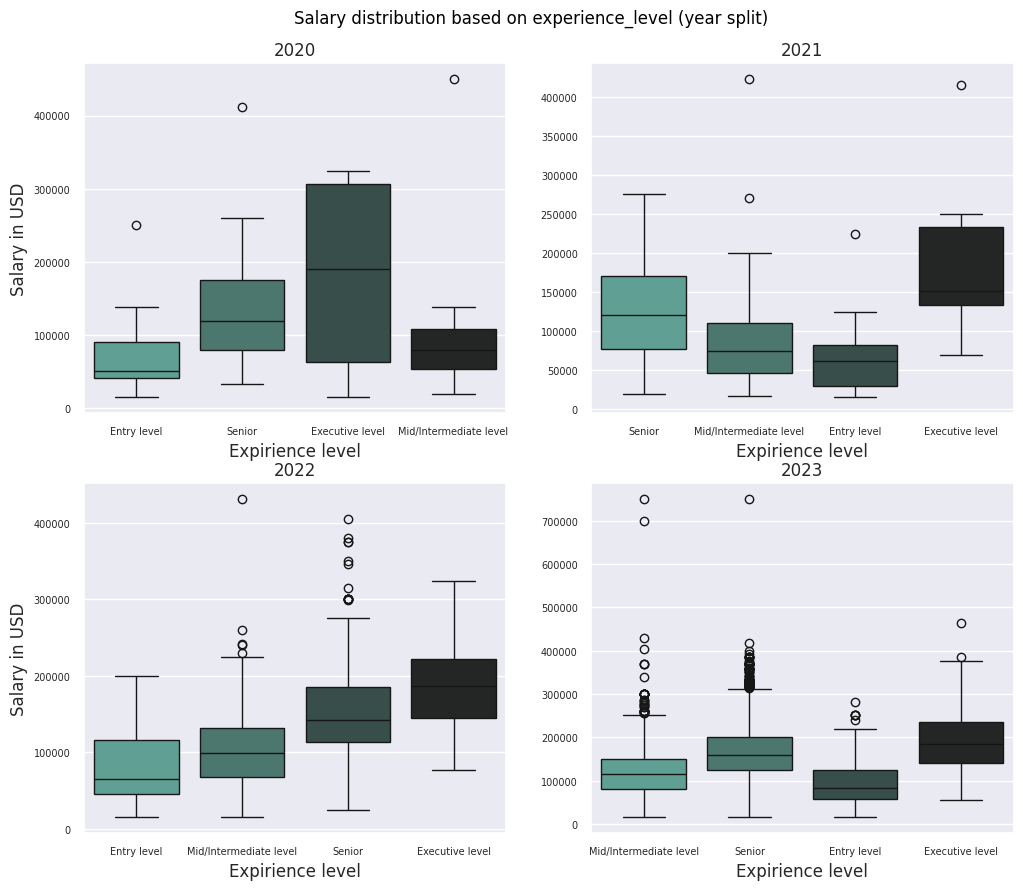

In [25]:
fig, ax = plt.subplots(2,2, figsize= (12, 10)) #, sharey='all')


data20 = data.loc[data['work_year']==2020, ['experience_level', 'salary_in_usd']]
x20, y20 = data20['experience_level'], data20['salary_in_usd']
data21 = data.loc[data['work_year']==2021, ['experience_level', 'salary_in_usd']]
x21, y21 = data21['experience_level'], data21['salary_in_usd']
data22 = data.loc[data['work_year']==2022, ['experience_level', 'salary_in_usd']]
x22, y22 = data22['experience_level'], data22['salary_in_usd']
data23 = data.loc[data['work_year']==2023, ['experience_level', 'salary_in_usd']]
x23, y23 = data23['experience_level'], data23['salary_in_usd']

sns.set(rc={'xtick.labelsize':7,
            'ytick.labelsize':7})

plt.gcf().text(.30, .92,
               "Salary distribution based on experience_level (year split)",
               fontsize = 12,
               color='Black')

sns.boxplot(ax=ax[0,0], x=x20, y=y20, palette='dark:#5A9_r').set(title=('2020'), xlabel=('Expirience level'), ylabel=('Salary in USD'))
sns.boxplot(ax=ax[0,1], x=x21, y=y21, palette='dark:#5A9_r').set(title=('2021'), xlabel=('Expirience level'), ylabel=(''))
sns.boxplot(ax=ax[1,0], x=x22, y=y22, palette='dark:#5A9_r').set(title=('2022'), xlabel=('Expirience level'), ylabel=('Salary in USD'))
sns.boxplot(ax=ax[1,1], x=x23, y=y23, palette='dark:#5A9_r').set(title=('2023'), xlabel=('Expirience level'), ylabel=(''))

plt.show()

Jak zmieniało się wynagrodzenie w zależności od wielkości firmy oferującej pracę?

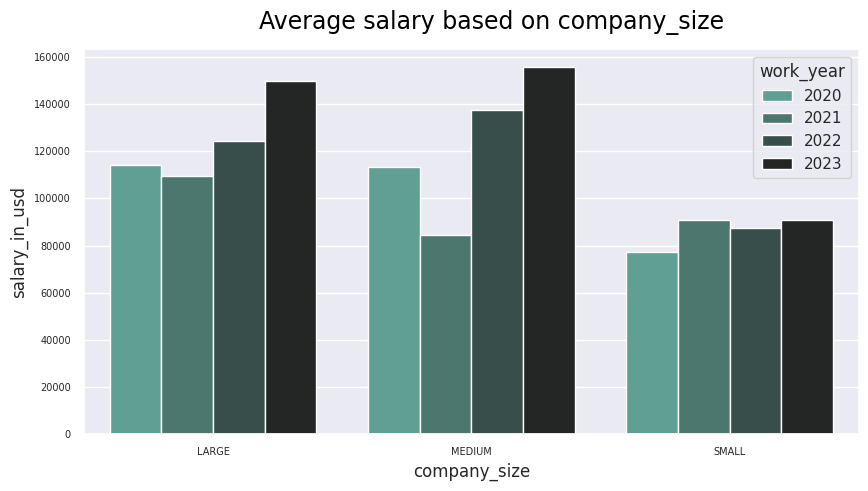

In [26]:
plt.figure(figsize=(10,5))
data_s2 = data.groupby(['work_year', 'company_size']).salary_in_usd.mean().reset_index()

sns.barplot(x= data_s2['company_size'], y= data_s2['salary_in_usd'], hue= data_s2['work_year'], palette='dark:#5A9_r')

sns.set(rc={'xtick.labelsize':10,
            'ytick.labelsize':10})

plt.gcf().text(.30, .92,
               "Average salary based on company_size",
               fontsize = 17,
               color='Black')


plt.show()

<ipython-input-27-084fbab3a938>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-084fbab3a938>:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-084fbab3a938>:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-084fbab3a938>:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




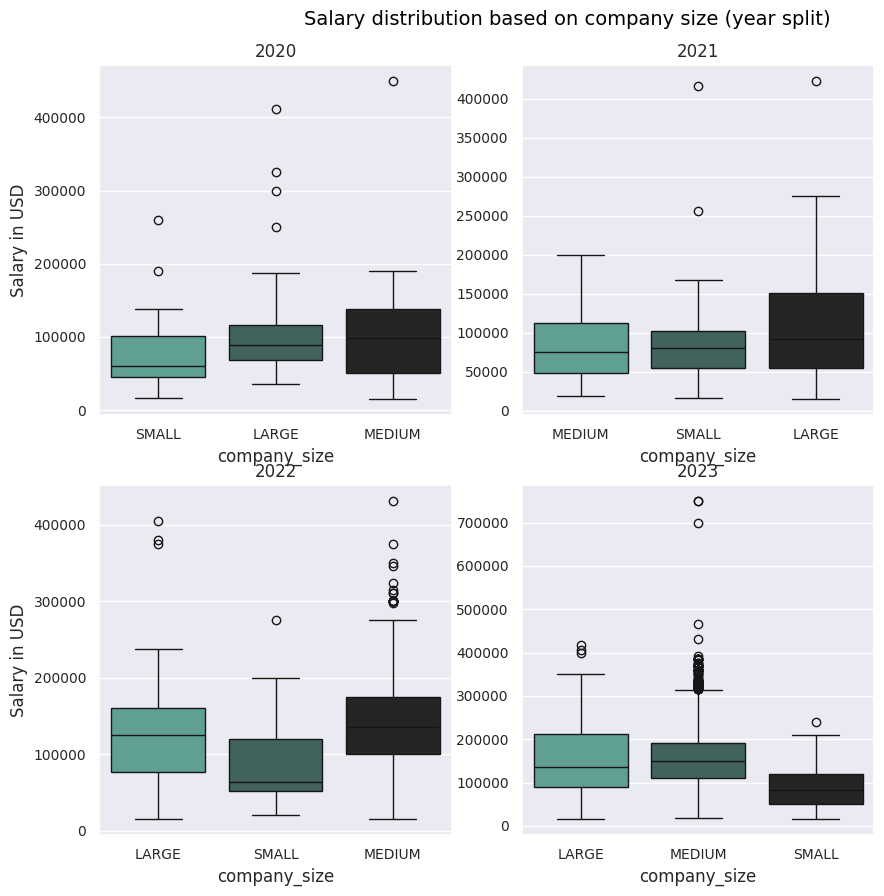

In [27]:
fig, ax = plt.subplots(2,2, figsize= (10, 10))


data20 = data.loc[data['work_year']==2020, ['company_size', 'salary_in_usd']]
x20, y20 = data20['company_size'], data20['salary_in_usd']
data21 = data.loc[data['work_year']==2021, ['company_size', 'salary_in_usd']]
x21, y21 = data21['company_size'], data21['salary_in_usd']
data22 = data.loc[data['work_year']==2022, ['company_size', 'salary_in_usd']]
x22, y22 = data22['company_size'], data22['salary_in_usd']
data23 = data.loc[data['work_year']==2023, ['company_size', 'salary_in_usd']]
x23, y23 = data23['company_size'], data23['salary_in_usd']

sns.set(rc={'xtick.labelsize':8,
            'ytick.labelsize':8})

plt.gcf().text(.33, .92,
               "Salary distribution based on company size (year split)",
               fontsize = 14,
               color='Black')

sns.boxplot(ax=ax[0,0], x=x20, y=y20, palette='dark:#5A9_r').set(title=('2020'), xlabel=('company_size'), ylabel=('Salary in USD'))
sns.boxplot(ax=ax[0,1], x=x21, y=y21, palette='dark:#5A9_r').set(title=('2021'), xlabel=('company_size'), ylabel=(''))
sns.boxplot(ax=ax[1,0], x=x22, y=y22, palette='dark:#5A9_r').set(title=('2022'), xlabel=('company_size'), ylabel=('Salary in USD'))
sns.boxplot(ax=ax[1,1], x=x23, y=y23, palette='dark:#5A9_r').set(title=('2023'), xlabel=('company_size'), ylabel=(''))

plt.show()

Top 10 specjalności według wynagrodzenia

In [28]:
Top10 = data.groupby('job_title').agg({'salary_in_usd':'median'}).round(2).sort_values('salary_in_usd', ascending=False).head(10)
Top10

,salary_in_usd
job_title,
Analytics Engineering Manager,399880.0
Data Science Tech Lead,375000.0
Managing Director Data Science,300000.0
AWS Data Architect,258000.0
Cloud Data Architect,250000.0
Head of Data,226500.0
Director of Data Science,217000.0
AI Architect,209968.0
Data Science Director,201000.0


In [29]:
job_df = pd.DataFrame(data['job_title'].value_counts().reset_index())
job_df.rename(columns = {'index':'Role','job_title':'frequency'}, inplace = True)


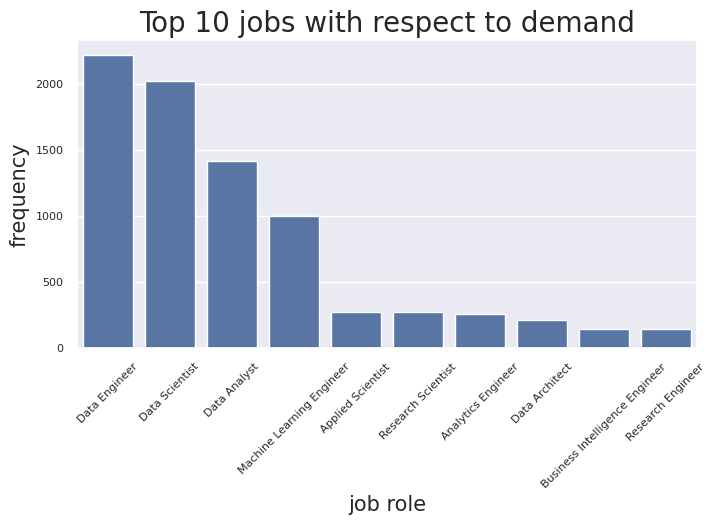

In [30]:
plt.figure(figsize=(8,4))
plt.title("Top 10 jobs with respect to demand",fontsize=20)
sns.barplot(x=job_df["Role"][:10],y=job_df['frequency'][:10])
plt.ylabel("frequency",fontsize=15)
plt.xlabel("job role",fontsize=15)
plt.xticks(rotation=45)
plt.show()

In [31]:
def assign_broader_category(job_title):
    data_engineering = ["Data Engineer", "Data Analyst", "Analytics Engineer", "BI Data Analyst", "Business Data Analyst", "BI Developer", "BI Analyst", "Business Intelligence Engineer", "BI Data Engineer", "Power BI Developer"]
    data_scientist = ["Data Scientist", "Applied Scientist", "Research Scientist", "3D Computer Vision Researcher", "Deep Learning Researcher", "AI/Computer Vision Engineer"]
    machine_learning = ["Machine Learning Engineer", "ML Engineer", "Lead Machine Learning Engineer", "Principal Machine Learning Engineer"]
    data_architecture = ["Data Architect", "Big Data Architect", "Cloud Data Architect", "Principal Data Architect"]
    management = ["Data Science Manager", "Director of Data Science", "Head of Data Science", "Data Scientist Lead", "Head of Machine Learning", "Manager Data Management", "Data Analytics Manager"]

    if job_title in data_engineering:
        return "Data Engineering"
    elif job_title in data_scientist:
        return "Data Science"
    elif job_title in machine_learning:
        return "Machine Learning"
    elif job_title in data_architecture:
        return "Data Architecture"
    elif job_title in management:
      return "Management"
    else:
        return "Other"

# Apply the function to the 'job_title' column and create a new column 'job_category'
data['job_category'] = data['job_title'].apply(assign_broader_category)

In [32]:
job_category_df = pd.DataFrame(data['job_category'].value_counts().reset_index())
job_category_df.rename(columns = {'index':'category','job_category':'frequency'}, inplace = True)


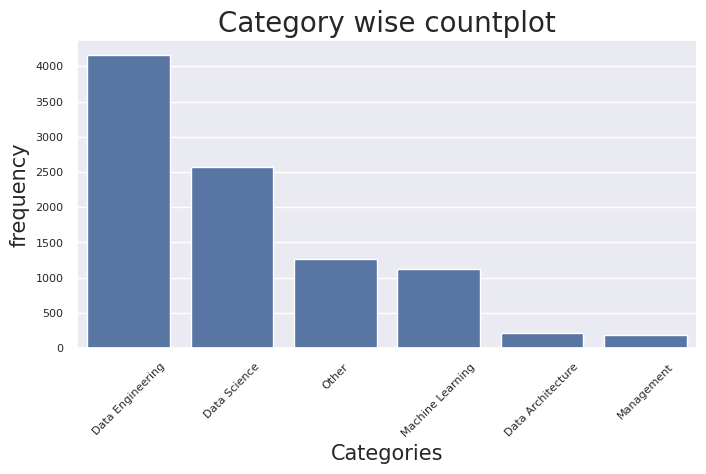

In [33]:
plt.figure(figsize=(8,4))
plt.title("Category wise countplot",fontsize=20)
sns.barplot(x=job_category_df["category"],y=job_category_df['frequency'])
plt.ylabel("frequency",fontsize=15)
plt.xlabel("Categories",fontsize=15)
plt.xticks(rotation=45)
plt.show()

#Analiza korelacji

In [34]:
categorical_columns = ['experience_level', 'employment_type', 'remote_ratio','company_size','job_category']
numerical_columns = ['salary_in_usd']
dummy_variables = pd.get_dummies(data, columns=categorical_columns, drop_first=False)

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scale the numerical columns
scaled_numerical = scaler.fit_transform(data[numerical_columns])

# Convert the scaled numerical columns
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns=numerical_columns)

In [36]:
 #Usunięcie oryginalnych kolumn numerycznych
dummy_variables = dummy_variables.drop(numerical_columns, axis=1)

# сoncatenate zmienne fikcyjne i skalowane kolumny liczbowe
processed_df = pd.concat([dummy_variables, scaled_numerical_df], axis=1)
processed_df = processed_df.drop(['work_year', 'salary'], axis=1)

<ipython-input-37-2c56973c8c71>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



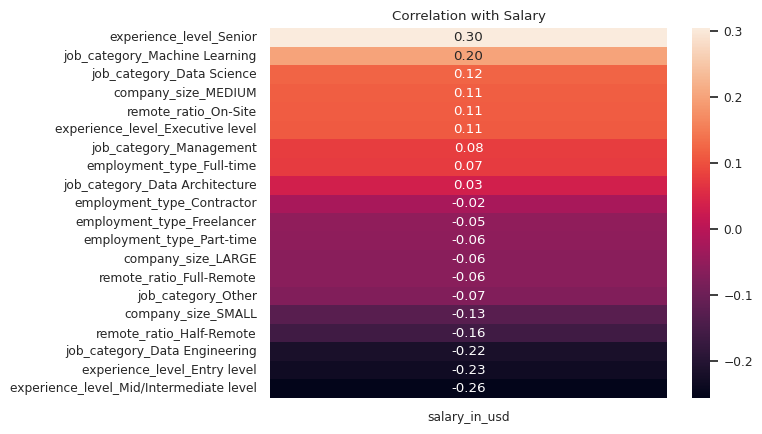

In [37]:
corr = processed_df.corr()
target_corr = corr['salary_in_usd'].drop('salary_in_usd')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("tab10")
sns.heatmap(target_corr_sorted.to_frame(), cmap="rocket", annot=True, fmt='.2f')
plt.title('Correlation with Salary')
plt.show()

#Analiza wymaganych umiejętności


In [39]:
#https://drive.google.com/file/d/12J0TnLpJKhc6Xei_YQNKngEdyxSAAleT/view?usp=sharing

df = pd.read_csv('https://drive.google.com/uc?id=12J0TnLpJKhc6Xei_YQNKngEdyxSAAleT', encoding='iso-8859-1')

In [40]:
df.head(2)

,Company,Job Title,Location,Job Type,Experience level,Salary,Requirment of the company,Facilities
0,SGS,Clinical Data Analyst,"Richardson, TX, United States",Full Time,Entry-level,48K+ *,"Computer Science,Data quality,Genetics,Mathematics,SAS,Statistics",",,,,"
1,Ocorian,AML/CFT & Data Analyst,"Ebène, Mauritius",Full Time,Entry-level,48K+ *,"Agile,Data management,Finance,Security,,",",,,,"


In [41]:
duplicate_rows = df[df.duplicated()]
duplicate_rows.shape

(202, 8)

In [42]:
df['Salary_num']=df['Salary'].str.extract(r'(\d+)')
df['Salary_num']=df['Salary_num'].astype(float)*1000

In [43]:
print(df.columns)


Index(['Company', 'Job Title', 'Location', 'Job Type', 'Experience level',
       'Salary', 'Requirment of the company ', 'Facilities', 'Salary_num'],
      dtype='object')


In [44]:
df = df.rename(columns={'Job Type': 'Job_Type'})
df = df.rename(columns={'Experience level': 'Experience_level'})


In [45]:
df['Experience_level'] = df['Experience_level'].astype('category')
df['Job_Type'] = df['Job_Type'].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Company                     3197 non-null   object  
 1   Job Title                   3197 non-null   object  
 2   Location                    3197 non-null   object  
 3   Job_Type                    3197 non-null   category
 4   Experience_level            2962 non-null   category
 5   Salary                      3009 non-null   object  
 6   Requirment of the company   3198 non-null   object  
 7   Facilities                  3198 non-null   object  
 8   Salary_num                  3009 non-null   float64 
dtypes: category(2), float64(1), object(6)
memory usage: 181.6+ KB


In [47]:
hard_skills_dict = {
    'Python': r"python",
    'R': r"[\b\s/]r[\s,\.]",
    'Excel': r"excel",
    'SQL': r"sql",
    'NoSQL': r"\bNo[\s,-]sql[\s]",
    'PowerBI': r"power[\s]BI",
    'Tableau': r"tableau",
    'SPSS': r'\bSPSS\b',
    'Big Data': r"\sbig\sdata\s",
    'SAP BI': r"SAP[\s]BI",
    'MongoDB': r"MongoDB",
    'Hadoop': r"Hadoop",
    'SAS': r"\bSAS\b",
    'VBA': r"\bvba\b",
    'AWS': r"\baws\b",
    'Git': r"\bGit",
    'QlikView': r"\bQlikView",
    'Oracle BI': r"oracle[\n]BI",
'Scala': r"Scala",
    'Dashboard': r"\bDashboard[s]",
    'Spark': r"Spark",
    'Matlab': r"Matplotlib",
    'Linux': r"linux",
    'Unix': r"unix",
    'Looker': r"looker",
    'C# or C++': r"\bC[#\+\+]",
    'Java': r"java",
    'PowerPivot': r"Power[\s]Pivot",
    'PowerQuery': r"Power[\s]Query",
    'BigQuery': r"Big[\s]Query",
    'Apache Cassandra': r"[\b\s]Cassandra[\b\s]",
    'Neo4j': r"Neo4j",
    'TensorFlow': r"TensorFlow"
}

hard_skills_count = {}


for key, search in hard_skills_dict.items():
    hard_skills_count[key] = df['Requirment of the company '].str.contains(search, flags = re.IGNORECASE).sum()

df_skills = pd.DataFrame.from_dict(hard_skills_count, orient = 'index') \
                        .sort_values(0, ascending = False) \
                        .reset_index() \
                        .rename(columns = {'index': 'Skills', 0: 'Count'})

df_skills['Relative Frecuency'] = (df_skills['Count'] / sum(df_skills['Count'])) *100
df_skills['Relative Frecuency'] = df_skills['Relative Frecuency'].apply(lambda x: round(x, 2))

# Remove values less than '1' per cent in its Relative Frequency
df_skills = df_skills.drop(df_skills[df_skills['Relative Frecuency'] < 1.00].index, axis = 0)

df_skills.head(df_skills.shape[0])

,Skills,Count,Relative Frecuency
0,AWS,862,36.60
1,Excel,349,14.82
2,Python,298,12.65
3,SQL,178,7.56
4,PowerBI,152,6.45
5,Git,124,5.27
6,Looker,80,3.40
7,Linux,72,3.06
8,Hadoop,57,2.42
9,Java,55,2.34


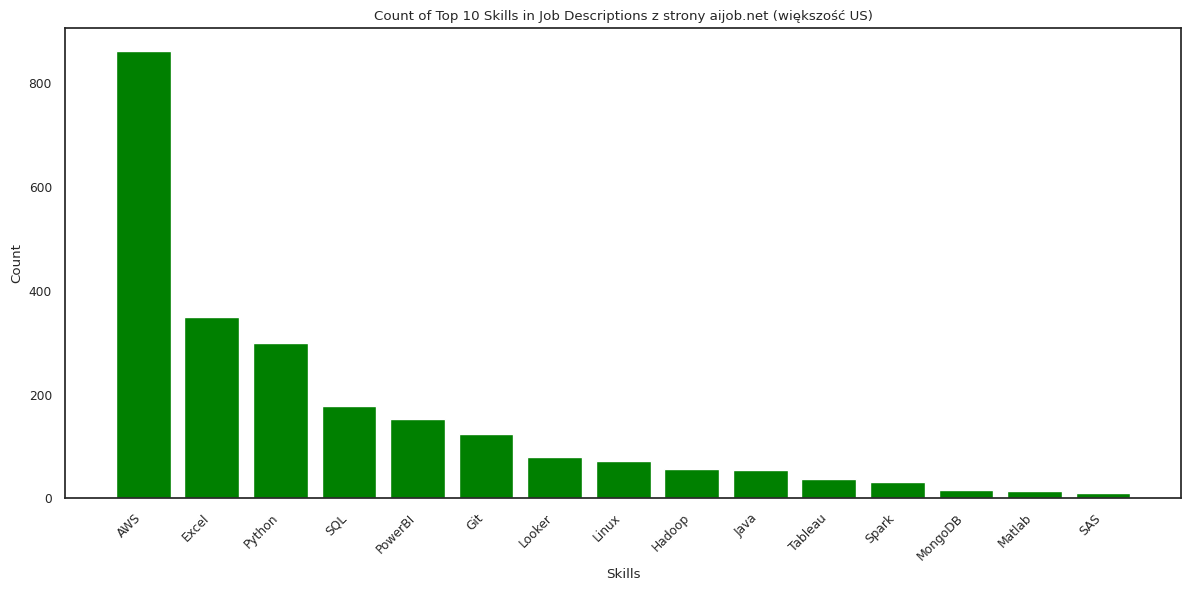

In [48]:
df_skills = pd.DataFrame.from_dict(hard_skills_count, orient='index') \
                        .sort_values(0, ascending=False) \
                        .head(15)
# Wykreśl wykres słupkowy
plt.figure(figsize=(12, 6))
plt.bar(df_skills.index, df_skills[0], color='green')
plt.xlabel('Skills')
plt.ylabel('Count')
plt.title('Count of Top 10 Skills in Job Descriptions z strony aijob.net (większość US)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [46]:
df_Requirment = df.groupby('Experience_level')['Requirment of the company '].apply(lambda x: ''.join(x)).reset_index()

In [49]:
def List_Requirment(data):
    df_List_Requirment = df_Requirment[df_Requirment['Experience_level'] == data]['Requirment of the company ']
    Requirment_list = [skill.strip() for skills in df_List_Requirment for skill in skills.split(',') if skill.strip() != ' ']
    Requirment_list = list(filter(lambda x: x != '', Requirment_list))

    Requirment_counts = pd.Series(Requirment_list).value_counts().head(25)

    # Create a bar chart
    plt.figure(figsize=(8, 5))
    plt.bar(Requirment_counts.index, Requirment_counts.values)

    # Customize the plot
    plt.xlabel('Requirment of the company')
    plt.ylabel('Frequency')
    plt.title(f'Requirment list for {data}')

    # Rotate x-axis labels if needed
    plt.xticks(rotation=-90)

     # Display the plot
    plt.tight_layout()
    plt.show()

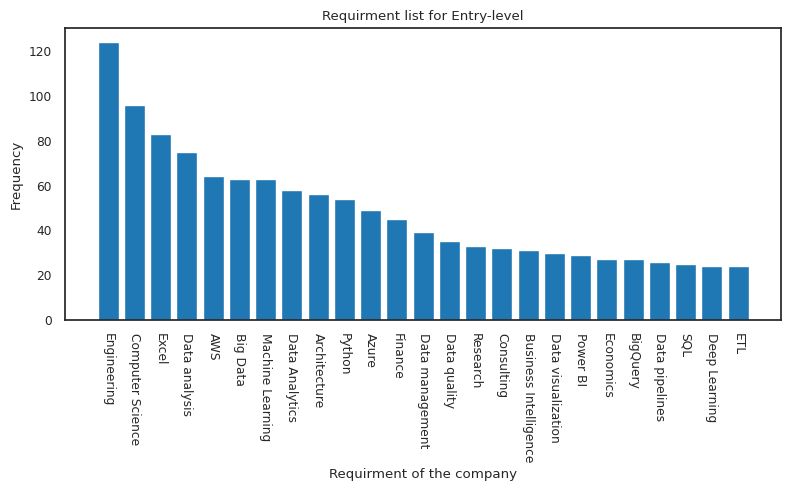

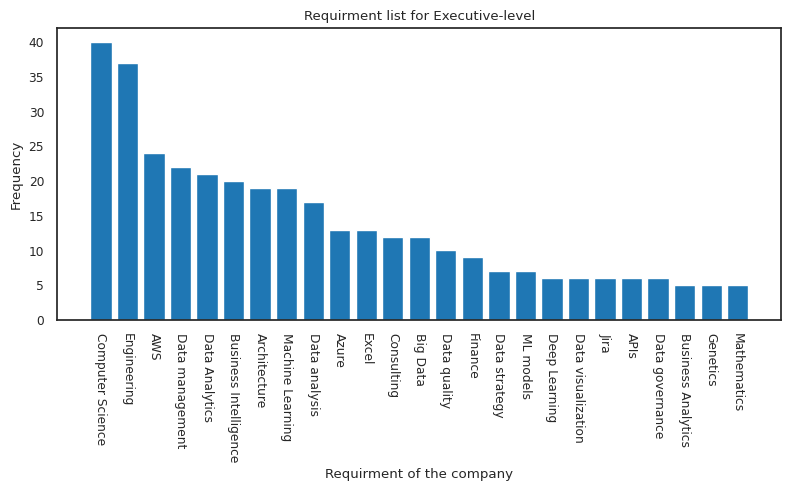

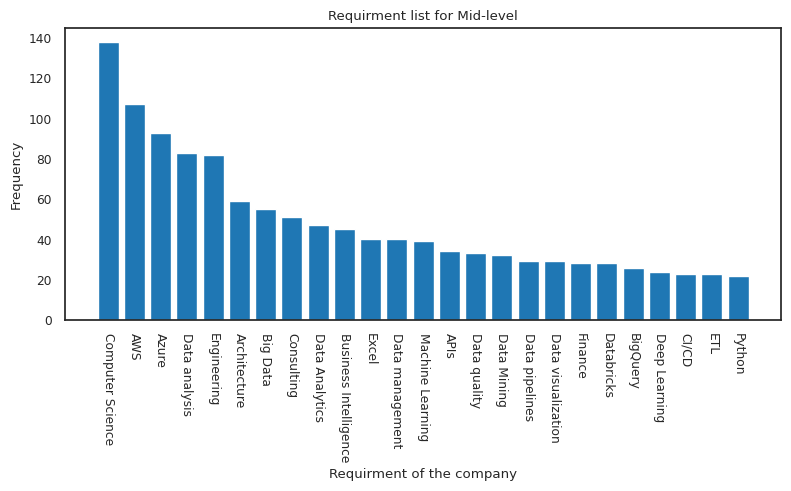

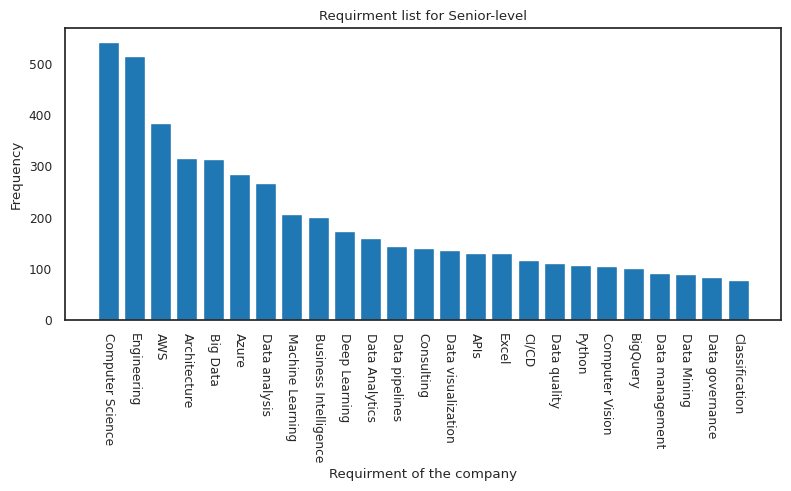

In [50]:
for data in df_Requirment['Experience_level'].unique():
    List_Requirment(data)

In [51]:
df_Requirment = df.groupby('Experience_level')['Requirment of the company '].apply(lambda x: ''.join(x)).reset_index()

In [52]:
def WorCloud(data):
    df_WordCloud = df_Requirment[df_Requirment['Experience_level'] == data]
    text_data =  df_WordCloud['Requirment of the company '].str.cat(sep=', ')

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='White').generate(text_data)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for {data}', pad = 20, size = 16)
    plt.axis('off')
    plt.show()

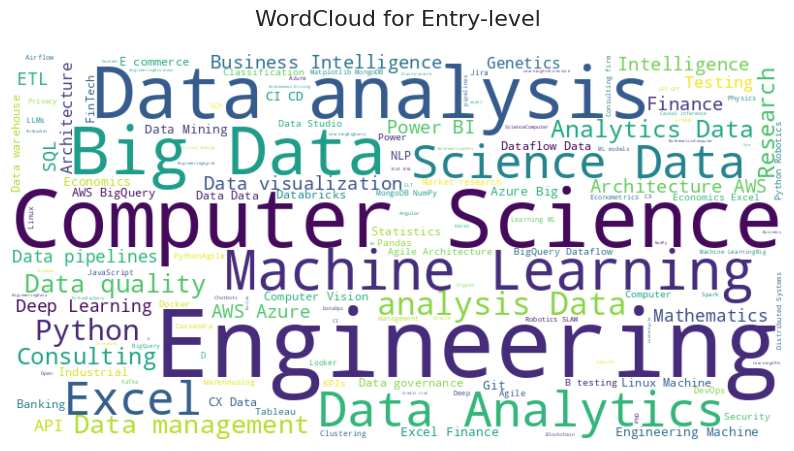

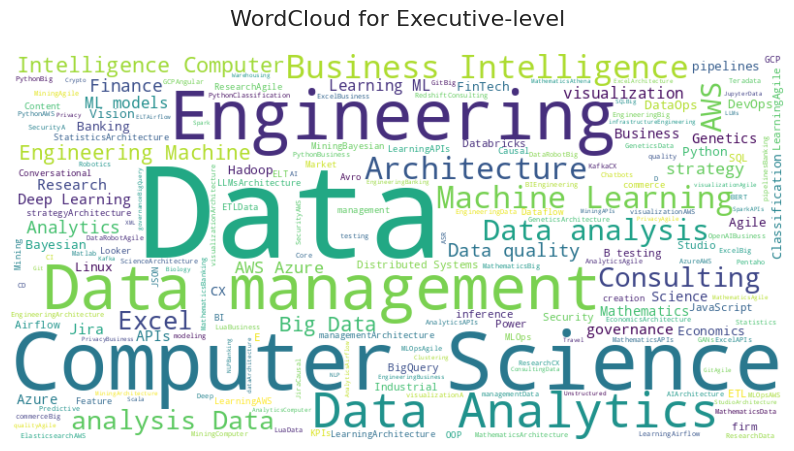

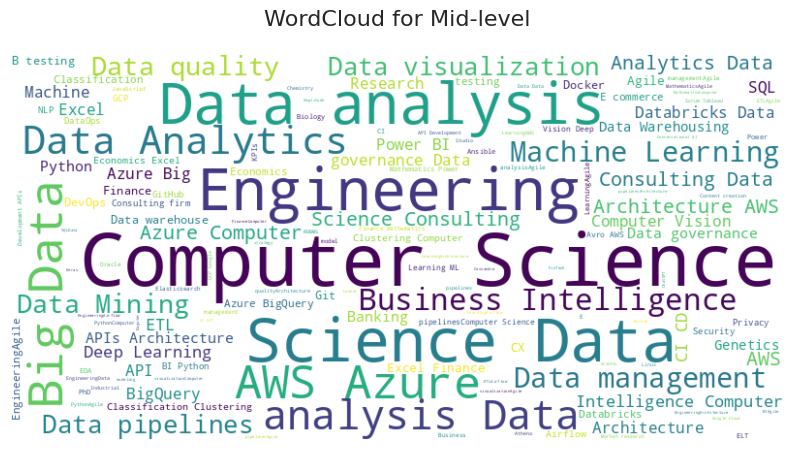

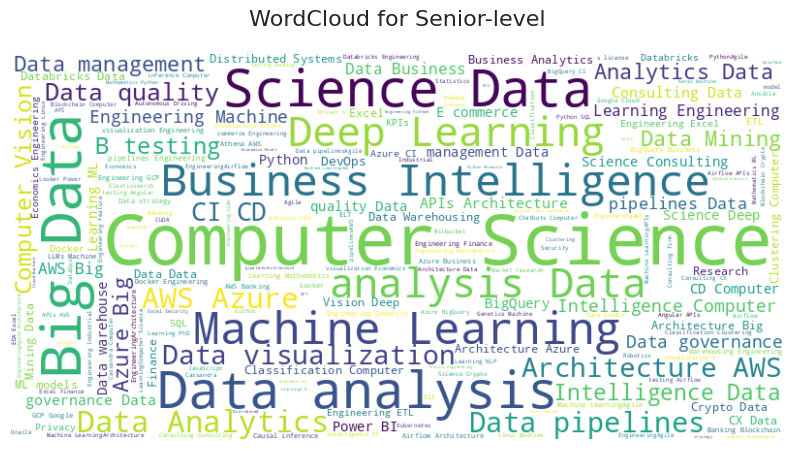

In [53]:
for data in df_Requirment['Experience_level'].unique():
    WorCloud(data)

In [54]:
df.isnull().sum()

Company                         1
Job Title                       1
Location                        1
Job_Type                        1
Experience_level              236
Salary                        189
Requirment of the company       0
Facilities                      0
Salary_num                    189
dtype: int64

https://www.kaggle.com/datasets/czobii/linkedin-dataset?select=Cleaned_Data.csv Ten zbiór danych jest podzbiorem ogłoszeń o pracę na LinkedIn w dniach 25-31 października 2023 roku. Zawiera 2200 ogłoszeń o pracę z regionu Europy (Niemcy, Austria), które pojawiają się po jednym ze słów kluczowych Data analyst, data scientist, data engineer.

Lista zawiera nazwę stanowiska, firmę, lokalizację, opis stanowiska i liczbę kandydatów (należy pamiętać, że jest cenzurowana zarówno dla wartości poniżej 25, jak i powyżej 200).

Istnieją dodatkowe zmienne, które nie są konieczne i są po prostu zmiennymi binarnymi, które sygnalizują, czy dana umiejętność jest wymieniona w opisie stanowiska, czy nie (np. 1 dla SQL oznacza, że jest wymieniona jako
umiejętność, 0 oznacza, że nie jest).





In [55]:
#https://drive.google.com/file/d/1I497kNP-e5uBh7PCLTuwuAlD1XeI1O_L/view?usp=sharing
lin = pd.read_csv('https://drive.google.com/uc?id=1I497kNP-e5uBh7PCLTuwuAlD1XeI1O_L', encoding='iso-8859-1')
lin.head(2)

Unnamed: 0                                                       job_title  \
0           0                               Software Quality Engineer (m/f/d)   
1           1  DevOps Engineer (m/f/d) â Innovation and Technology Services   

   company_name                    company_location    post_date  \
0  IFCO SYSTEMS     Gmunden, Upper Austria, Austria  2 weeks ago   
1           ABB  Eggelsberg, Upper Austria, Austria  2 weeks ago   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [56]:
lin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2228 entries, 0 to 2227
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        2228 non-null   int64 
 1   job_title         2228 non-null   object
 2   company_name      2228 non-null   object
 3   company_location  2228 non-null   object
 4   post_date         2228 non-null   object
 5   job_description   2228 non-null   object
 6   applicant_number  2228 non-null   object
 7   applicants        2228 non-null   int64 
 8   country           2228 non-null   object
 9   city              2228 non-null   object
 10  unit              2228 non-null   int64 
 11  time_unit         2228 non-null   object
 12  job_title_clean   2228 non-null   object
 13  SQL               2228 non-null   int64 
 14  Python            2228 non-null   int64 
 15  Spark or Hive     2228 non-null   int64 
 16  PowerBI           2228 non-null   int64 
 17  Scikit-learn  

In [ ]:
duplicate_rows = lin[lin.duplicated()]
duplicate_rows.shape

(0, 25)

In [57]:
lin['job_title_clean'].value_counts()

Other             889
Engineer          615
Data Analyst      565
Data Scientist     91
BI                 68
Name: job_title_clean, dtype: int64

In [58]:
pat_lead=re.compile(r'lead|principal|iii|iv',re.I)
pat_sr=re.compile(r'senior|sr.|sr|ii',re.I)
pat_jr=re.compile(r'junior|jr|jr.|entry|i',re.I)


In [59]:
def job_title(row):
    if re.match(pat_lead,row['job_title']):
        return 'Lead'
    if re.match(pat_sr,row['job_title']):
        return 'Senior'
    if re.match(pat_jr,row['job_title']):
        return 'Junior'

lin['Job Level']=lin.apply(job_title,axis=1)
lin['Job Level'].value_counts()


Senior    389
Junior    122
Lead       41
Name: Job Level, dtype: int64

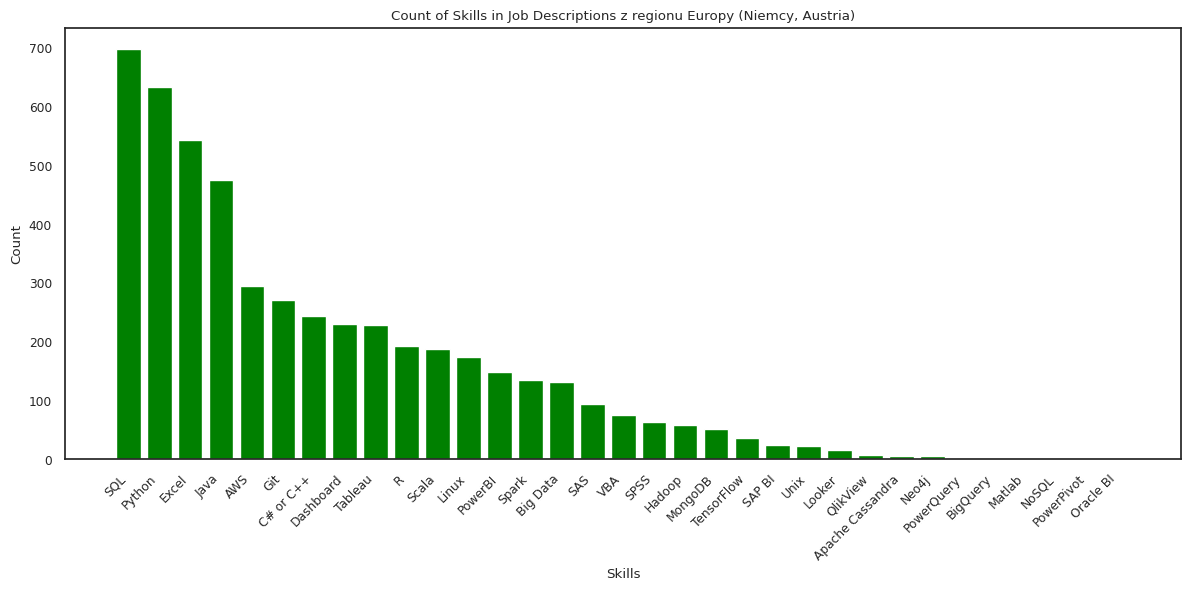

In [60]:
hard_skills_dict = {
    'Python': r"python",
    'R': r"[\b\s/]r[\s,\.]",
    'Excel': r"excel",
    'SQL': r"sql",
    'NoSQL': r"\bNo[\s,-]sql[\s]",
    'PowerBI': r"power[\s]BI",
    'Tableau': r"tableau",
    'SPSS': r'\bSPSS\b',
    'Big Data': r"\sbig\sdata\s",
    'SAP BI': r"SAP[\s]BI",
    'MongoDB': r"MongoDB",
    'Hadoop': r"Hadoop",
    'SAS': r"\bSAS\b",
    'VBA': r"\bvba\b",
    'AWS': r"\baws\b",
    'Git': r"\bGit",
    'QlikView': r"\bQlikView",
    'Oracle BI': r"oracle[\n]BI",
'Scala': r"Scala",
    'Dashboard': r"\bDashboard[s]",
    'Spark': r"Spark",
    'Matlab': r"Matplotlib",
    'Linux': r"linux",
    'Unix': r"unix",
    'Looker': r"looker",
    'C# or C++': r"\bC[#\+\+]",
    'Java': r"java",
    'PowerPivot': r"Power[\s]Pivot",
    'PowerQuery': r"Power[\s]Query",
    'BigQuery': r"Big[\s]Query",
    'Apache Cassandra': r"[\b\s]Cassandra[\b\s]",
    'Neo4j': r"Neo4j",
    'TensorFlow': r"TensorFlow"
}

hard_skills_count = {}


for key, search in hard_skills_dict.items():
    hard_skills_count[key] = lin['job_description'].str.contains(search, flags = re.IGNORECASE).sum()

df_skills = pd.DataFrame.from_dict(hard_skills_count, orient = 'index') \
                        .sort_values(0, ascending = False) \
                        .reset_index() \
                        .rename(columns = {'index': 'Skills', 0: 'Count'})

df_skills['Relative Frecuency'] = (df_skills['Count'] / sum(df_skills['Count'])) *100
df_skills['Relative Frecuency'] = df_skills['Relative Frecuency'].apply(lambda x: round(x, 2))

# Remove values less than '1' per cent in its Relative Frequency
df_skills = df_skills.drop(df_skills[df_skills['Relative Frecuency'] < 1.00].index, axis = 0)

df_skills.head(df_skills.shape[0])

df_skills = pd.DataFrame.from_dict(hard_skills_count, orient='index') \
                        .sort_values(0, ascending=False) \
                        .reset_index() \
                        .rename(columns={'index': 'Skills', 0: 'Count'})

# Wykreśl wykres słupkowy
plt.figure(figsize=(12, 6))
plt.bar(df_skills['Skills'], df_skills['Count'], color='green')
plt.xlabel('Skills')
plt.ylabel('Count')
plt.title('Count of Skills in Job Descriptions z regionu Europy (Niemcy, Austria)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Jak widać, wykresy wymaganych umiejętności różnią się zarówno w zależności od poziomu kompetencji, jak i terytoriów, które opisują dane